In [1]:
import numpy as np
from matplotlib import pyplot as plt         
from scipy.linalg import solve    
import scipy.sparse as sparse             # Sparse matrices
from scipy.sparse.linalg import spsolve   # Linear solver for sparse matrices
newparams = {'figure.figsize': (8.0, 4.0), 'axes.grid': True,
             'lines.markersize': 8, 'lines.linewidth': 2,
             'font.size': 14}
plt.rcParams.update(newparams)
from mpl_toolkits.mplot3d import Axes3D     # For 3-d plot
from matplotlib import cm

### Parameters

In [2]:
# Number of steps
N = 4

# mu
mu = 1

# v vector
v1 = 0
v2 = 0

### Respective functions

In [3]:
def u(x, y):
    return x**2 + 2*(y**2)

def f(x, y):
    return -6

# y = 1
def g_n(x):
    return u(x,1)

# y = 0
def g_s(x):
    return u(x,0)

# x = 0
def g_w(y):
    return u(0,y)

# x = 1
def g_e(y):
    return u(1,y)

In [ ]:
'''
def u(x, y):
    return np.sin(x)*np.cos(y)

def f(x, y, v1, v2):
    return 2*np.sin(x)*np.cos(y)
'''

### Build Diagonal Matrix

In [4]:
def A_matrix(h, mu, Ni, Ni2, a_p, a_s, a_w, a_e, a_n):
    
    A_0  = a_p  * np.eye(Ni2, k=0)
    A_R1 = a_e * np.eye(Ni2, k=1)
    A_RN = a_n * np.eye(Ni2, k=Ni)
    A_L1 = a_w * np.eye(Ni2, k=-1)
    A_LN = a_s * np.eye(Ni2, k=-Ni)
    
    return A_0 + A_R1 + A_RN + A_L1 + A_LN

### Solver Function

In [5]:
def pde_solve(N, mu, v1, v2):
    
    # Step size
    h = 1/N
    
    # Make grid
    x = np.linspace(0, 1, N+1)
    y = np.linspace(0, 1, N+1) 

    # Inner points
    xi = x[1:-1]       
    yi = y[1:-1] 
    Xi, Yi = np.meshgrid(xi, yi)
    Ni = N-1       # Number of inner points in each direction
    Ni2 = Ni**2    # Number of inner points in total
    
    # Exact Solution (MUST BE CHANGED IF U IS CHANGED)
    U_exact = Xi**2 + 2*(Yi**2)

    
    # Coefficients
    a_p = (4 * mu) / h**2
    a_e = - mu/h**2 + v1/(2*h)
    a_n = - mu/h**2 + v2/(2*h)
    a_w = - mu/h**2 - v1/(2*h)
    a_s = - mu/h**2 - v2/(2*h)
    
    # Create A matrix
    A = A_matrix(h, mu, Ni, Ni2, a_p, a_s, a_w, a_e, a_n)
    A = sparse.csr_matrix(A)
    A = A.tocsr()
    
    
    # Handle interior stack-edges
    for i in range(1, Ni):
        edge = i*Ni
        A[edge-1, edge] = 0
        A[edge, edge-1] = 0
            
    # Fill inn b vector
    b = np.zeros(Ni2)
    for j in range(Ni):
        for i in range(Ni):
            b[j*Ni + i] = f(x[i+1], y[j+1])
        
    # Include the boundary conditions
    b[0:Ni] = b[0:Ni] - a_s*g_s(xi)                        # y=0
    b[Ni2-Ni:Ni2] = b[Ni2-Ni:Ni2] - a_n*g_n(xi)            # y=1
    b[0:Ni2:Ni] = b[0:Ni2:Ni] - a_w*g_w(yi)                # x=0
    b[Ni-1:Ni2:Ni] = b[Ni-1:Ni2:Ni] - a_e*g_e(yi)          # x=1
    
    # Solve system numerically
    U = spsolve(A, b)
    U = np.reshape(U, (Ni, Ni))
    
    return U, U_exact, Xi, Yi, h

### Solutions

In [6]:
U, U_exact, Xi, Yi, h = pde_solve(10, mu, v1, v2)
# Print the error
#print('\nU=\n', U)
print('The error is {:.2e}'.format(np.max(np.max(abs(U-U_exact)))))

The error is 8.88e-16


### Plot Results

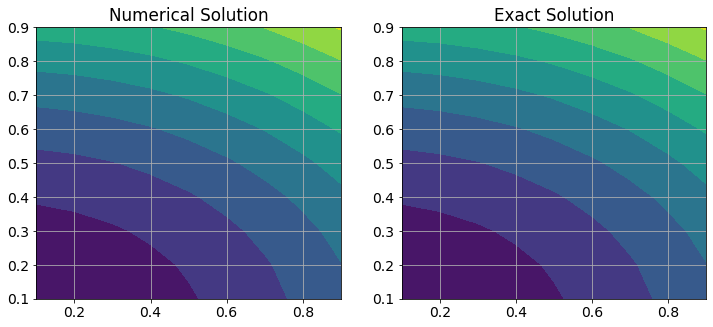

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
ax1.contourf(Xi, Yi, U)
ax1.title.set_text('Numerical Solution')
ax2.contourf(Xi, Yi, U_exact)
ax2.title.set_text('Exact Solution')

### Problem 1 b - Error analysis 
#### Numerical verification

In [10]:
# We want to measure the error for different stepsizes. 

def convergence(mu, v1, v2):
    P = 4   # Number of different stepsizes
    Hconv = np.zeros(P) #list of stepsizes (x-axis)
    Econv = np.zeros(P) #list of errors (y-axis)
    N = 10  # The least number of intervals (#grid points-1)
    for p in range(P):
        U, U_exact, Xi, Yi, h = pde_solve(N, mu, v1, v2)
        Eh = U_exact-U 
        Econv[p] = np.max(np.abs(Eh))
        Hconv[p] = Xi[0,1]-Xi[0,0] #the stepsize for y and x direction are the same
        N =N*2  # Double the number of intervals
    order = np.polyfit(np.log(Hconv),np.log(Econv),1)[0]   # Measure the order - returns highest power first
    return Hconv, Econv, order

We will now choose a new test problem.
Here, the problem is adapted to the exact solution $u(x)=$. 
According to the theoretical result, this would then give an upper bound for the error for the function is 
$$$$

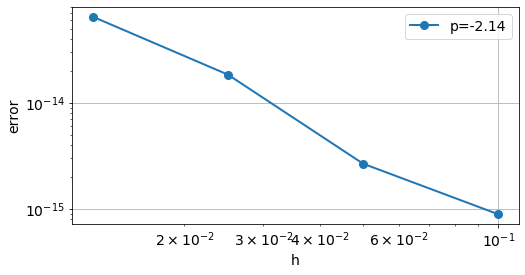

In [11]:
#convergence plot
H, E, p = convergence(mu=1, v1=0, v2=0)
plt.loglog(H,E,'o-', label='p={:.2f}'.format(p))
#plt.loglog(H,H*np.exp(1),'--',label='upper bound') # fyll inn upper bound (teoretisk her)
plt.grid('on')
plt.xlabel('h')
plt.ylabel('error')
plt.legend()